# 덧셈 규칙 학습

In [ ]:
import warnings
warnings.filterwarnings('ignore', module='requests')

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
#from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import Image

## 데이터 준비

### 데이터 로드 및 전처리

In [ ]:
file_path = './dataset/addition.txt'

In [ ]:
questions, answers = [], []
# todo
for line in open(file_path, 'r'):
    idx = line.find('_')
    questions.append(line[:idx])
    answers.append(line[idx:-1])

In [ ]:
len(questions), len(answers)

(50000, 50000)

In [ ]:
# 최대 길이 계산
MAX_QUESTION_LEN = max(len(q) for q in questions) # 7
MAX_ANSWER_LEN = max(len(a) for a in answers) # 5

MAX_QUESTION_LEN, MAX_ANSWER_LEN

(7, 5)

### 어휘사전(Vocabulary)

In [ ]:
class Vocabulary:
    def __init__(self, questions, answers):
        self.char_to_id = {}
        self.id_to_char = {}
        self.idx = 0

        for question in questions:
            self.add_char(question)
        for answer in answers:
            self.add_char(answer)

    def add_char(self, text):
        for char in text:
            # todo
            if char not in self.char_to_id:
                self.char_to_id[char] = self.idx
                self.id_to_char[self.idx] = char
                self.idx += 1

    def __len__(self): # vocab.__len__() ---> len(vocab)
        return len(self.char_to_id)

In [ ]:
# Vocabulary 생성
vocab = Vocabulary(questions, answers)

In [ ]:
vocab.__len__(), len(vocab)

(13, 13)

In [ ]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

13

In [ ]:
vocab.char_to_id

{'1': 0,
 '6': 1,
 '+': 2,
 '7': 3,
 '5': 4,
 ' ': 5,
 '2': 6,
 '0': 7,
 '3': 8,
 '9': 9,
 '8': 10,
 '4': 11,
 '_': 12}

In [ ]:
vocab.id_to_char

{0: '1',
 1: '6',
 2: '+',
 3: '7',
 4: '5',
 5: ' ',
 6: '2',
 7: '0',
 8: '3',
 9: '9',
 10: '8',
 11: '4',
 12: '_'}

### Dataset

In [ ]:
# 케라스의 tokenizer.texts_to_sequences(text_data) 역할
question_sequences = [[vocab.char_to_id[c] for c in q] for q in questions]
answer_sequences = [[vocab.char_to_id[c] for c in a] for a in answers]

# 패딩으로 고정길이 만들기
encoder_input = pad_sequences(question_sequences, maxlen=MAX_QUESTION_LEN, padding='post')
decoder_data = pad_sequences(answer_sequences, maxlen=MAX_ANSWER_LEN, padding='post')

decoder_input = decoder_data[:, :-1]
decoder_target = decoder_data[:, 1:]

In [ ]:
encoder_input[0], decoder_input[0], decoder_target[0]

(array([0, 1, 2, 3, 4, 5, 5]), array([12,  9,  0,  5]), array([9, 0, 5, 5]))

In [ ]:
# 질문
for i in encoder_input[0]:
    i = int(i)
    char = vocab.id_to_char[i]
    print(char, end='')
print()

# 답변 (input)
for i in decoder_input[0]:
    i = int(i)
    char = vocab.id_to_char[i]
    print(char, end='')
print()

# 답변 (target)
for i in decoder_target[0]:
    i = int(i)
    char = vocab.id_to_char[i]
    print(char, end='')

16+75  
_91 
91  

In [ ]:
def prepare_dataset(questions, answers, vocab, max_question_len, max_answer_len):
    # 케라스의 tokenizer.texts_to_sequences(text_data) 역할

    # 입력 데이터 반전용
    reversed_questions = [q[::-1] for q in questions]
    question_sequences = [[vocab.char_to_id[c] for c in q] for q in reversed_questions]

    # question_sequences = [[vocab.char_to_id[c] for c in q] for q in questions]
    answer_sequences = [[vocab.char_to_id[c] for c in a] for a in answers]

    # 패딩으로 고정길이 만들기
    encoder_input = pad_sequences(question_sequences, maxlen=MAX_QUESTION_LEN, padding='post')
    decoder_data = pad_sequences(answer_sequences, maxlen=MAX_ANSWER_LEN, padding='post')

    decoder_input = decoder_data[:, :-1]
    decoder_target = decoder_data[:, 1:]

    return encoder_input, decoder_input, decoder_target

In [ ]:
# 데이터 분할
train_questions, test_questions, train_answers, test_answers = train_test_split(
    questions, answers, test_size=0.1, random_state=42
)
train_questions, val_questions, train_answers, val_answers = train_test_split(
    train_questions, train_answers, test_size=0.1, random_state=42
)

In [ ]:
# 데이터셋 준비
train_encoder_input, train_decoder_input, train_decoder_target = prepare_dataset(
    train_questions, train_answers, vocab, MAX_QUESTION_LEN, MAX_ANSWER_LEN
)
val_encoder_input, val_decoder_input, val_decoder_target = prepare_dataset(
    val_questions, val_answers, vocab, MAX_QUESTION_LEN, MAX_ANSWER_LEN
)
test_encoder_input, test_decoder_input, test_decoder_target = prepare_dataset(
    test_questions, test_answers, vocab, MAX_QUESTION_LEN, MAX_ANSWER_LEN
)

In [ ]:
train_encoder_input.shape, train_decoder_input.shape, train_decoder_target.shape

((40500, 7), (40500, 4), (40500, 4))

## 모델 생성: `Seq2Seq + Attention`

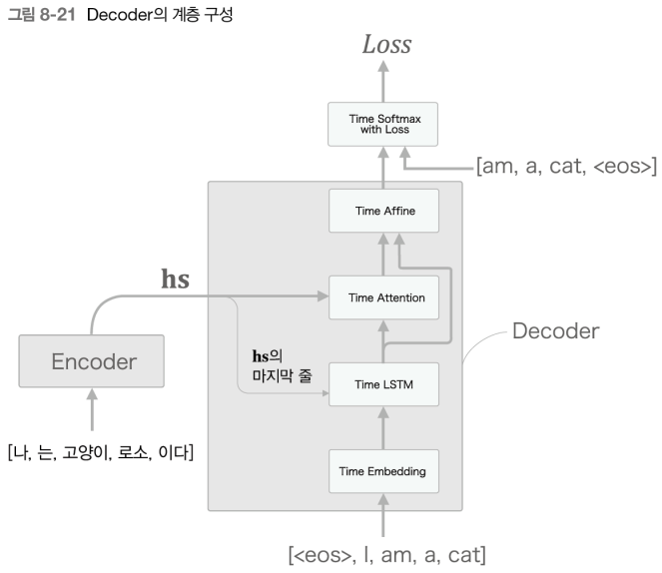

In [ ]:
Image("./images/Attention 디코더 적용.png")

In [ ]:
# 하이퍼 파라미터 설정
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MAX_EPOCHS = 50
EMBEDDING_DIM = 16
HIDDEN_SIZE = 128

MAX_ENCODER_LEN = 7  # 인코더 입력 최대 길이
MAX_DECODER_LEN = 4  # 디코더 입력 최대 길이

### Encoder 구성

In [ ]:
# 인코더 정의
encoder_inputs = layers.Input(shape=(MAX_ENCODER_LEN,))
encoder_embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm_layer = layers.LSTM(units=HIDDEN_SIZE, return_sequences=True, return_state=True)
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm_layer(encoder_embeddings)
encoder_state = [encoder_state_h, encoder_state_c]
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, encoder_state_h, encoder_state_c])
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 embedding (Embedding)       (None, 7, 16)             208       
                                                                 
 lstm (LSTM)                 [(None, 7, 128),          74240     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 74,448
Trainable params: 74,448
Non-trainable params: 0
_________________________________________________________________


### Attention Decoder 구성

In [ ]:
# 디코더 정의
decoder_inputs = layers.Input(shape=(MAX_DECODER_LEN,))
decoder_embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_lstm_layer = layers.LSTM(units=HIDDEN_SIZE, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm_layer(decoder_embeddings, initial_state=encoder_state)

# Attention 계층 추가
attention_layer = layers.Attention()
contexts = attention_layer([decoder_outputs, encoder_outputs])
attention_outputs = layers.Concatenate(axis=-1)([decoder_outputs, contexts])

decoder_dense_layer = layers.Dense(VOCAB_SIZE, activation='softmax')
outputs = decoder_dense_layer(attention_outputs)

decoder_model = tf.keras.Model(inputs=[encoder_outputs, encoder_state, decoder_inputs], outputs=outputs)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 4, 16)        208         ['input_4[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

### Seq2Seq + Attention 모델

In [ ]:
# Seq2Seq Attention 모델

Seq2Seq_Attention = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
Seq2Seq_Attention.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7, 16)        208         ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 4, 16)        208         ['input_4[0][0]']                
                                                                                            

## 모델 설정 (손실함수, 옵티마이저 선택)

In [ ]:
Seq2Seq_Attention.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 모델 훈련

In [ ]:
history = Seq2Seq_Attention.fit(
    [train_encoder_input, train_decoder_input],
    np.expand_dims(train_decoder_target, -1),  # (batch, timesteps, 1) 형태로 변환
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=(
        [val_encoder_input, val_decoder_input],
        np.expand_dims(val_decoder_target, -1)
    )
)

Epoch 1/50
317/317 [==============================] - 8s 13ms/step - loss: 1.8660 - accuracy: 0.3294 - val_loss: 1.7486 - val_accuracy: 0.3469
Epoch 2/50
317/317 [==============================] - 3s 10ms/step - loss: 1.7092 - accuracy: 0.3523 - val_loss: 1.6639 - val_accuracy: 0.3664
Epoch 3/50
317/317 [==============================] - 3s 11ms/step - loss: 1.6149 - accuracy: 0.3834 - val_loss: 1.5448 - val_accuracy: 0.4118
Epoch 4/50
317/317 [==============================] - 4s 13ms/step - loss: 1.4522 - accuracy: 0.4488 - val_loss: 1.3477 - val_accuracy: 0.4859
Epoch 5/50
317/317 [==============================] - 4s 13ms/step - loss: 1.2502 - accuracy: 0.5334 - val_loss: 1.1604 - val_accuracy: 0.5689
Epoch 6/50
317/317 [==============================] - 4s 14ms/step - loss: 1.0727 - accuracy: 0.6009 - val_loss: 0.9915 - val_accuracy: 0.6291
Epoch 7/50
317/317 [==============================] - 4s 13ms/step - loss: 0.9036 - accuracy: 0.6622 - val_loss: 0.8266 - val_accuracy: 0.6867

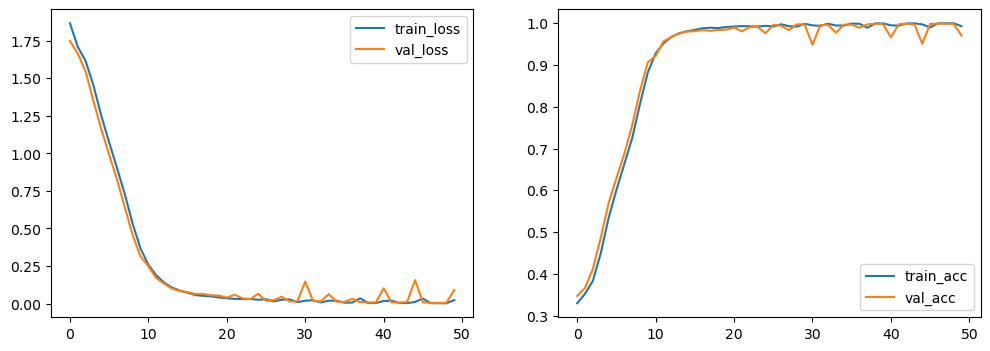

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='train_loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()

# accuracies
ax2.plot(history.history['accuracy'], label='train_acc')
ax2.plot(history.history['val_accuracy'], label='val_acc')
ax2.legend()
plt.show()

## 모델 예측

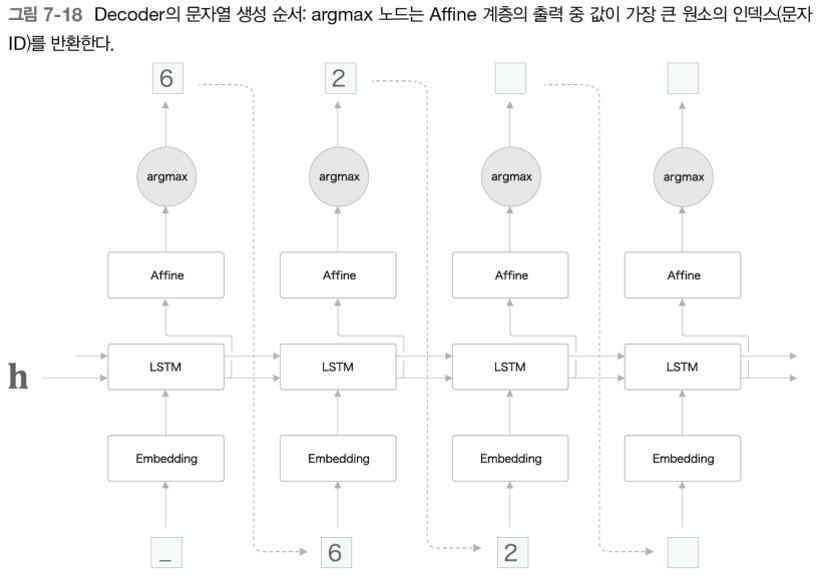

In [ ]:
Image("./images/Decoder 추론(생성).png")

In [ ]:
decoder_state_input_h = layers.Input(shape=(HIDDEN_SIZE,))
decoder_state_input_c = layers.Input(shape=(HIDDEN_SIZE,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = layers.Input(shape=(1,))
decoder_inputs_emb_single = decoder_embedding_layer(decoder_inputs_single)  # (batch_size, 1, EMBEDDING_DIM)

lstm_outputs, decoder_state_h, decoder_state_c = decoder_lstm_layer(
    decoder_inputs_emb_single, initial_state=decoder_states_inputs
)

decoder_states = [decoder_state_h, decoder_state_c]

# 추가
encoder_outputs_input = layers.Input(shape=(MAX_ENCODER_LEN, HIDDEN_SIZE))
context = attention_layer([lstm_outputs, encoder_outputs_input])
attention_output = layers.Concatenate(axis=-1)([lstm_outputs, context])

decoder_output = decoder_dense_layer(attention_output)

inf_decoder_model = Model(
    inputs = [decoder_inputs_single, encoder_outputs_input] + decoder_states_inputs,
    outputs = [decoder_output] + decoder_states
)

In [ ]:
def predict_sequence(input_seq, max_decoder_len=MAX_DECODER_LEN):
    encoder_outputs, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)
    states_value = [enc_h, enc_c]
    start_token = vocab.char_to_id['_']
    target_seq = np.array([[start_token]])
    decoded_sequence = []

    for _ in range(max_decoder_len):
        outputs = inf_decoder_model.predict([target_seq, encoder_outputs] + states_value, verbose=0)
        output_tokens, h, c = outputs[0], outputs[1], outputs[2]
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_sequence.append(sampled_token_index)


        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    # 문자열로 변환
    question = ''.join([vocab.id_to_char.get(idx, '') for idx in input_seq.flatten()])
    guess = ''.join([vocab.id_to_char.get(idx, '') for idx in decoded_sequence])

    return guess

In [ ]:
test_question = "37+25  "
reversed_question = test_question[::-1]  # 입력 순서 반전
question_seq = [vocab.char_to_id.get(c, 0) for c in reversed_question]  # 0=UNK
question_padded = pad_sequences([question_seq], maxlen=MAX_ENCODER_LEN, padding='post')
prediction = predict_sequence(question_padded)
print(f"Question: {test_question}, Prediction: {prediction}")

Question: 37+25  , Prediction: 62  


## 모델 평가

In [ ]:
# 전체 시퀀스 정확도 계산 함수
def calculate_sequence_accuracy(encoder_input, decoder_target, vocab, max_decoder_len=MAX_DECODER_LEN):
    correct_count = 0
    total_count = len(encoder_input)

    for i in range(total_count):
        # 예측
        input_seq = encoder_input[i:i+1]
        predicted_seq = predict_sequence(input_seq)

        # 실제 정답 디코딩
        actual_tokens = []
        for idx in decoder_target[i]:
            actual_tokens.append(vocab.id_to_char.get(idx, ''))
        actual_answer = ''.join(actual_tokens)

        print('정답: ' , actual_answer)
        print('예측: ', predicted_seq)

        # 완전 일치 검사
        if actual_answer == predicted_seq:
            correct_count += 1
    print(correct_count)
    return correct_count / total_count

# 검증 데이터로 평가
val_accuracy = calculate_sequence_accuracy(
    test_encoder_input[:10],
    test_decoder_target[:10],
    vocab,

)

정답:  745 
예측:  745 
정답:  984 
예측:  984 
정답:  625 
예측:  625 
정답:  817 
예측:  817 
정답:  221 
예측:  221 
정답:  192 
예측:  192 
정답:  816 
예측:  816 
정답:  1056
예측:  1056
정답:  24  
예측:  24  
정답:  960 
예측:  960 
10
시퀀스 전체 정확도: 1.0000


In [ ]:
# 테스트 데이터로 모델 평가
test_loss, test_accuracy = Seq2Seq_Attention.evaluate(
    [test_encoder_input, test_decoder_input],
    np.expand_dims(test_decoder_target, -1),
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Token Accuracy: {test_accuracy:.4f}")

40/40 [==============================] - 1s 12ms/step - loss: 0.0871 - accuracy: 0.9685
Test Loss: 0.0871
Test Token Accuracy: 0.9685
